# Gaussian Mixture Models (GMM)

### Motivating GMM: the weakness of K-Means

In the previous section we have explored the K-Means algorithm. The non-probabilistic nature of k-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

Given simple blobs of data, the k-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye:

In [3]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

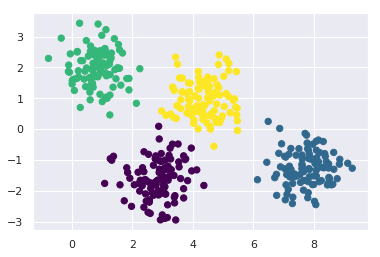

In [4]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. 

In [5]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

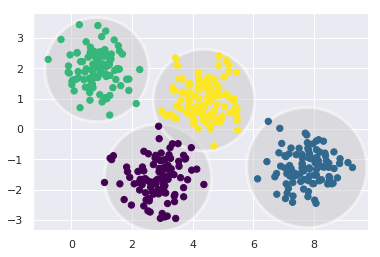

In [6]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

An important observation for k-means is that these cluster models must be circular: k-means has no built-in way of accounting for oblong or elliptical clusters. So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled

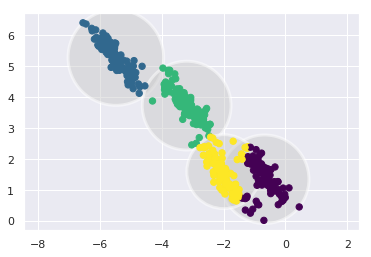

In [7]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

#### 2 Main Disadvantages of K-Means
- lack of flexibility in cluster shape
- lack of probabilistic cluster assignment

## GMM
A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset

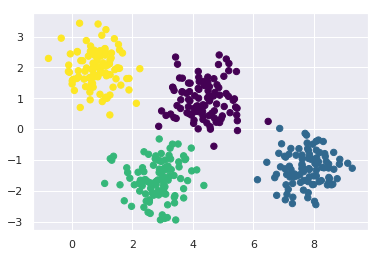

In [8]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments. 

This is done using the `predict_proba` method. 

This returns a matrix of size `[n_samples, n_clusters]` which measures the probability that any point belongs to the given cluster:

In [9]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.531 0.469 0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    1.    0.   ]]


We can visualize this uncertainty by, making the size of each point proportional to the certainty of its prediction

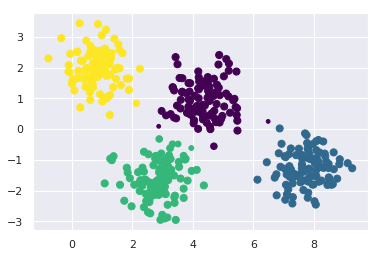

In [10]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Under the hood, a Gaussian mixture model is very similar to k-means: it uses an expectation–maximization approach:

1) Choose starting guesses for the location and shape

2) Repeat until converged:

- E-step: for each point, find weights encoding the probability of membership in each cluster
- M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights

each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model. 

In [11]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

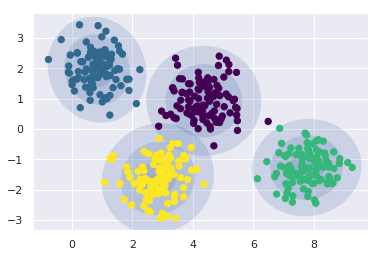

In [12]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters

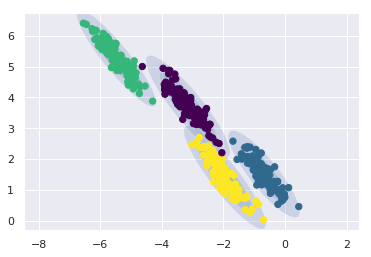

In [13]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

### Choosing the Covariance Type

The `covariance_type` parameter controls the degrees of freedom in each shape of the cluster. 

The default is `covariance_type="diag"`. This means that the size of the cluster along each dimension can be set independently. 

`covariance_type="spherical"` constrains the cluster such that all dimensions are equal. 

`covariance_type="full"` allows each cluster to be modelled as an eclipse with arbitrary orientation. 

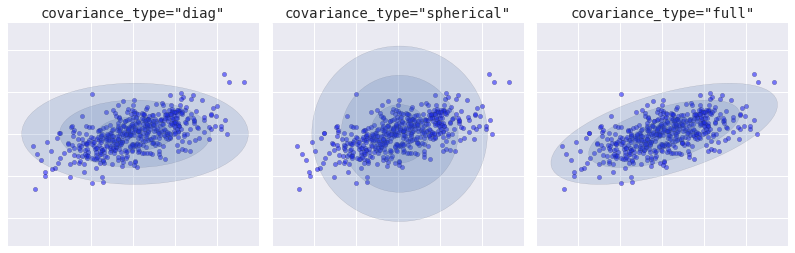

### GMM as Density Estimation

Although GMM is often classified as a clustering algorithm, it is actually an algorithm for density estimation. This difference is illustrated below:

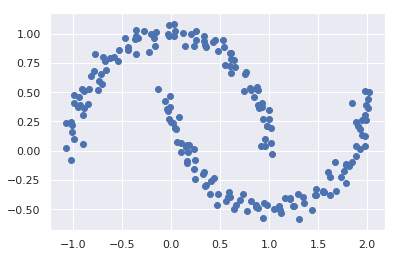

In [16]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

If we view this as a clustering model and try to fit a 2 component GMM, the results are not particularly useful:

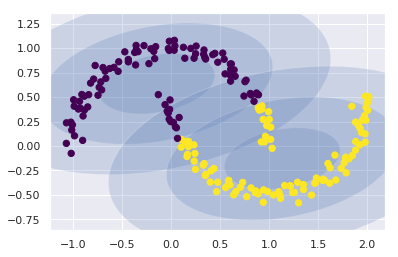

In [17]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

If we use more components and ignore the cluster labels, we get a fit that is much closer to the input data. 

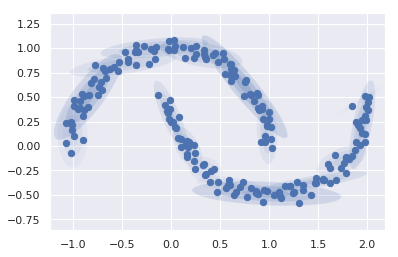

In [19]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall distribution of the input data.

Since GMM is a generative model, it provides us the recipe to generate new random data distributed similarly to our input. 

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

### Determining the number of Components

We can use AIC and BIC to determine the optimal number of components for our dataset. 

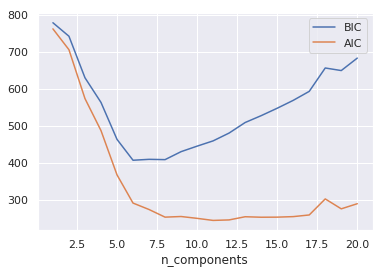

In [23]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use

### GMM for generating new data

In this example, we will generate new handwritten digits

In [24]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape


(1797, 64)

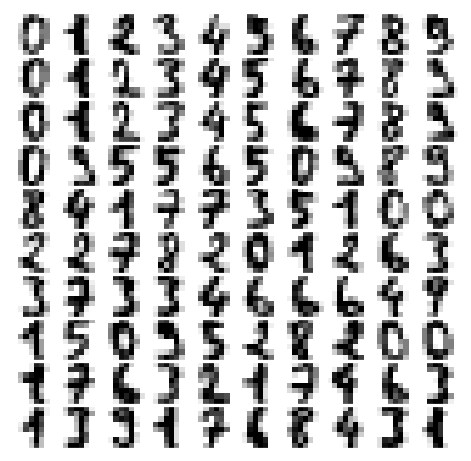

In [25]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

We first use PCA to reduce the number of dimensions of the data. 99% of the variance is preserved. 

In [26]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

Use AIC to estimate the number of components we should use. 

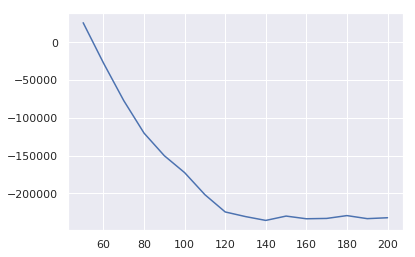

In [27]:
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

Based on the graph, we should use 110 components to minimize the AIC

In [29]:
gmm = GMM(140, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


Now we generate 100 samples in the 41 dimension space

In [33]:
data_new = gmm.sample(100)
data_new[0].shape

(100, 41)

Finally we use inverse transform of PCA to construct the new digits

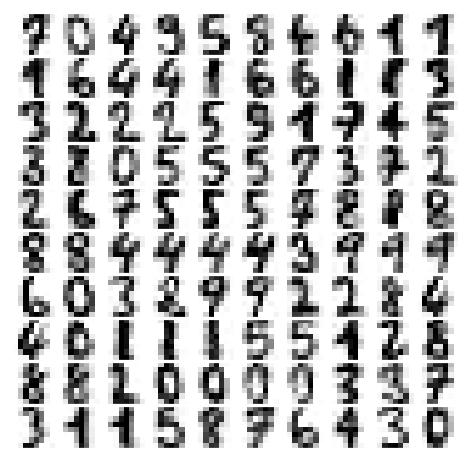

In [35]:
digits_new = pca.inverse_transform(data_new[0])
plot_digits(digits_new)